In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 64, bias=False),
            nn.ReLU(),
            nn.Linear(64, 12, bias=False),
            nn.ReLU(),
            nn.Linear(12, 3, bias=False)  # compressed representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12, bias=False),
            nn.ReLU(),
            nn.Linear(12, 64, bias=False),
            nn.ReLU(),
            nn.Linear(64, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 28 * 28, bias=False),
            nn.Sigmoid(),  # to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Example:
model = Autoencoder()
x = torch.randn(32, 28 * 28)
output = model(x)
print(output.shape)  # torch.Size([32, 784])

torch.Size([32, 784])


In [3]:
class TransposedAutoencoder(nn.Module):
    def __init__(self):
        super(TransposedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128, bias=False),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 64, bias=False),
            nn.LeakyReLU(0.01), # 0.01 is the negative slope
            nn.Linear(64, 12, bias=False),
            nn.LeakyReLU(0.01),
            nn.Linear(12, 3, bias=False)  # compressed representation
        )

    def forward(self, x):
        x = self.encoder(x)
        # Decode using by transposing the encoder layers
        layers = list(self.encoder.children())
        x = x.t()
        for layer in reversed(layers):
            if isinstance(layer, nn.Linear):
                weights = layer.weight.t()
                x = weights @ x
            else:  # LeakyReLU
                # Inverse of LeakyReLU
                x = torch.where(x >= 0, x, x / 0.01)
        
        x = x.t()
        return x


# Example:
model = TransposedAutoencoder()
x = torch.randn(32, 28 * 28)
output = model(x)
print(output.shape)
print(output)

torch.Size([32, 784])
tensor([[-1.9816e+01,  1.8779e+01, -2.3355e+01,  ...,  6.5852e+01,
          6.1950e+01,  8.1221e+01],
        [-1.6975e+01,  7.1016e+01, -6.6424e+01,  ...,  9.8970e+01,
          5.9576e+01,  1.4753e+02],
        [-2.0567e+01, -2.7858e+01, -8.8480e+00,  ...,  5.0026e+01,
          2.8238e+01,  4.0788e+01],
        ...,
        [-8.4345e+00,  6.8696e-02, -1.8865e+01,  ...,  5.0629e+01,
          3.1739e+01,  5.2350e+01],
        [-4.5458e-01, -1.4690e+01, -2.5026e+01,  ...,  9.5057e+01,
          4.4410e+01,  1.0322e+02],
        [-1.3046e+01,  8.2230e+01, -6.3889e+01,  ...,  1.0895e+02,
          7.2382e+01,  1.7207e+02]], grad_fn=<TBackward0>)


In [4]:
# Define the training loop
def train(model, train_loader, optimizer, criterion):
    model.train()
    loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)  # reconstruction loss
        loss.backward()
        optimizer.step()

        loss += loss.item()

    print(f'Loss: {loss / len(train_loader)}')


# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# model = Autoencoder()
model = TransposedAutoencoder()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss
criterion = nn.MSELoss()

# Train the model
for epoch in range(30):  # Train for 10 epochs
    print(f'Epoch {epoch}')
    train(model, train_loader, optimizer, criterion)


Epoch 0
Loss: 6.833580846432596e-05
Epoch 1
Loss: 6.333603960229084e-05
Epoch 2
Loss: 5.369682548916899e-05
Epoch 3
Loss: 5.461668115458451e-05
Epoch 4
Loss: 5.78854487685021e-05
Epoch 5
Loss: 5.824609979754314e-05
Epoch 6
Loss: 4.727567284135148e-05
Epoch 7
Loss: 4.062360676471144e-05
Epoch 8
Loss: 4.179582901997492e-05
Epoch 9
Loss: 3.631430081441067e-05
Epoch 10
Loss: 3.938433656003326e-05
Epoch 11
Loss: 4.4226369936950505e-05
Epoch 12
Loss: 3.8076352211646736e-05
Epoch 13
Loss: 4.379282472655177e-05
Epoch 14
Loss: 3.663539973786101e-05
Epoch 15
Loss: 3.593247674871236e-05
Epoch 16
Loss: 4.091722803423181e-05
Epoch 17
Loss: 3.3175674616359174e-05
Epoch 18
Loss: 4.154156340518966e-05
Epoch 19
Loss: 3.576303060981445e-05
Epoch 20
Loss: 4.0663489926373586e-05
Epoch 21
Loss: 4.251963400747627e-05
Epoch 22
Loss: 3.510157694108784e-05
Epoch 23
Loss: 3.679994915728457e-05
Epoch 24
Loss: 3.227494016755372e-05
Epoch 25
Loss: 3.263862890889868e-05
Epoch 26
Loss: 3.634480162872933e-05
Epoch 27

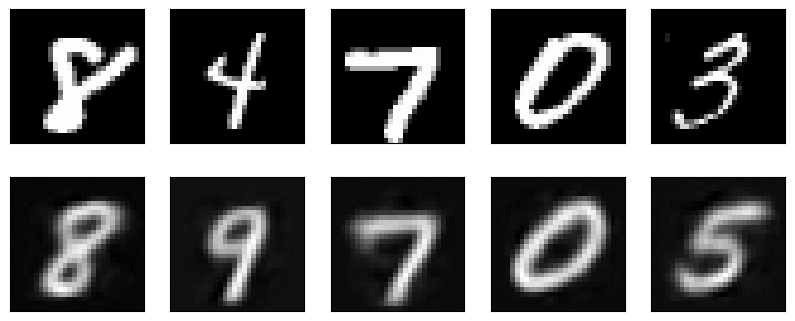

In [5]:
# Visualize the reconstructed images
import matplotlib.pyplot as plt

model.eval()
data, _ = next(iter(train_loader))
data = data.view(data.size(0), -1)
output = model(data)
data = data.detach().numpy()
output = output.detach().numpy()

n_images = 5
plt.figure(figsize=(10, 4))
for i in range(n_images):
    # display original
    ax = plt.subplot(2, n_images, i + 1)
    plt.imshow(data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)